# Exploring the Milky Way Through Stars

## Learning Goals
By the end of this tutorial, you will:
- Understand how to read in SDSS ASPCAP stellar parameters
- Learn a bit about stellar parameters and how astronomers label them
- Gain some intuition for our place in the Galaxy and Galactic trends

## Introduction
<p>In this notebook we're going to be exploring our galaxy by looking at stars around the Sun.</p>

<p>We are going to do this using data from two surveys, the <a href="http://www.sdss.org">Sloan Digital Sky Survey</a> (SDSS) and <a href="https://www.esa.int/Science_Exploration/Space_Science/Gaia">Gaia</a>. SDSS measured the spectra of millions of stars. The SDSS data reduction pipeline took these spectra and measured some important quantities about each individual star. This includes information about the composition of each star as well as the star's velocity towards or away from the Earth. Gaia measured the positions and motions of billions of stars, giving us lots of information about where an individual star is in the galaxy and how it is moving.</p>

## Imports
This tutorial requires three commonly used python packages
- _numpy_ for efficienct math with arrays
- _matplotlib_ for plotting
- _astropy_ for reading fits table

Missing packages can be installed via `pip install numpy matplotlib astropy` 

<p>Let's start by importing some libraries. The warnings import is entirely optional, but suppresses some annoying formatting errors that may appear on some computers.</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

# for plots
from matplotlib import rc

import warnings
warnings.filterwarnings('ignore')

### Loading data from a fits file

<p>We can now import our data file. This combines the parameters measured by SDSS and Gaia for lotes of different stars. It loads the data from our input file into a table.</p>

**Where**: you can download the data --> https://dr19.sdss.org/sas/dr19/spectro/astra/0.6.0/summary/astraAllStarASPCAP-0.6.0.fits.gz

**OR** if you are running this notebook on sciServer, the summary file is available at /home/idies/workspace/sdss_sas/dr19/spectro/astra/0.6.0/summary/

Below, the default loadpath is set to sciServer. If you download it locally, change loadpath as needed, e.g., "/Users/myuser/Downloads/"

Next, we'll use `astropy.fits` to load the file and choose the extension we want. In this case, BOSS data is in extension 1, but we want APOGEE data in extension 2.

In [2]:
filename='astraAllStarASPCAP-0.6.0.fits.gz'
#tb = fits.open(filename)
data = Table.read(filename, format='fits',hdu=2)

<p>Now lets have a look at the data columns</p>

In [3]:
data.colnames

['sdss_id',
 'sdss4_apogee_id',
 'gaia_dr2_source_id',
 'gaia_dr3_source_id',
 'tic_v8_id',
 'healpix',
 'lead',
 'version_id',
 'catalogid',
 'catalogid21',
 'catalogid25',
 'catalogid31',
 'n_associated',
 'n_neighborhood',
 'sdss5_target_flags',
 'sdss4_apogee_target1_flags',
 'sdss4_apogee_target2_flags',
 'sdss4_apogee2_target1_flags',
 'sdss4_apogee2_target2_flags',
 'sdss4_apogee2_target3_flags',
 'sdss4_apogee_member_flags',
 'sdss4_apogee_extra_target_flags',
 'ra',
 'dec',
 'l',
 'b',
 'plx',
 'e_plx',
 'pmra',
 'e_pmra',
 'pmde',
 'e_pmde',
 'gaia_v_rad',
 'gaia_e_v_rad',
 'g_mag',
 'bp_mag',
 'rp_mag',
 'j_mag',
 'e_j_mag',
 'h_mag',
 'e_h_mag',
 'k_mag',
 'e_k_mag',
 'ph_qual',
 'bl_flg',
 'cc_flg',
 'w1_mag',
 'e_w1_mag',
 'w1_flux',
 'w1_dflux',
 'w1_frac',
 'w2_mag',
 'e_w2_mag',
 'w2_flux',
 'w2_dflux',
 'w2_frac',
 'w1uflags',
 'w2uflags',
 'w1aflags',
 'w2aflags',
 'mag4_5',
 'd4_5m',
 'rms_f4_5',
 'sqf_4_5',
 'mf4_5',
 'csf',
 'zgr_teff',
 'zgr_e_teff',
 'zgr_logg',

<p>That's a lot of columns. Luckily we will only be dealing with a few of them.</p>

**Exercise**, determine how many stars your table has data for.

In [4]:
#enter your code here
#Possible solution:

len(data)

1095480

<p>Now let's make a map of our data on the sky.</p>

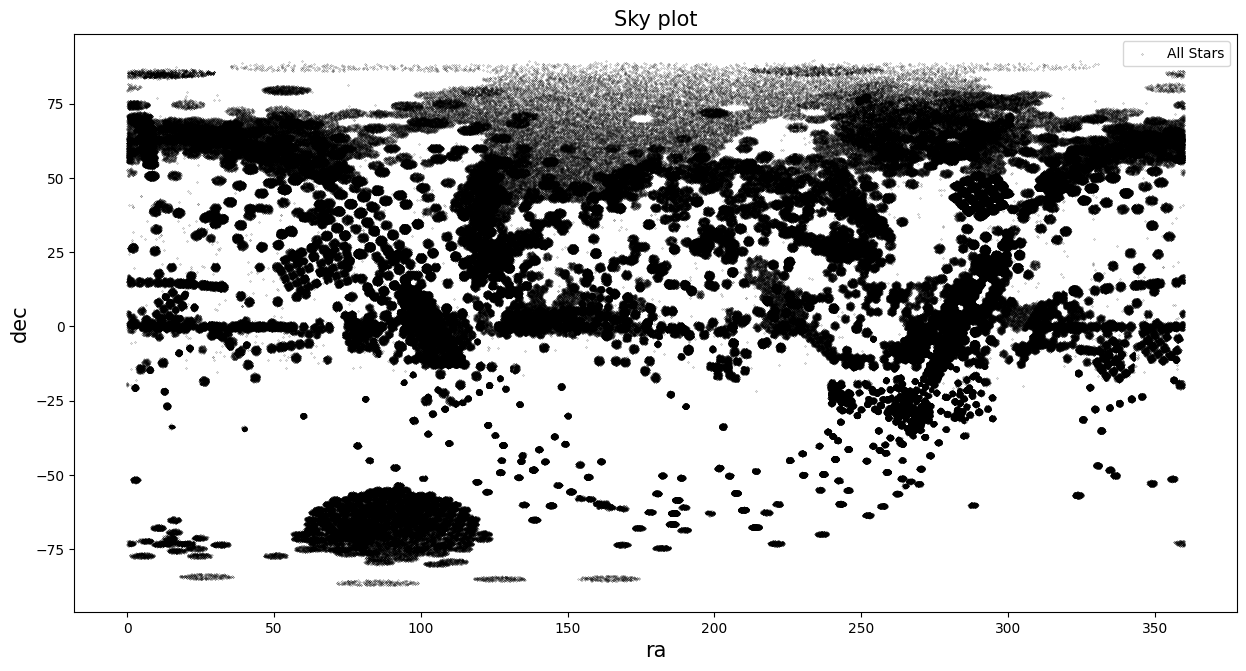

In [5]:
plt.figure(figsize=(15,7.5))
plt.scatter(data['ra'],data['dec'], color='black', marker='.', s=0.1,label="All Stars" )
plt.xlabel('ra', fontsize=15); plt.ylabel('dec', fontsize=15)
plt.title('Sky plot', fontsize=15)
plt.legend()

<p>What can you say about the distribution on the sky of the stars in your sample?</p>

<p>Gaia covered the whole sky but SDSS only has data from certain parts of the sky. This is a trade-off astronomers often face, cover as wide an area as possible or get as much detailed information on specific regions of the sky. This is a constant balancing act for astronomers designing surveys.</p>

<p>One thing you might notice is that near the celestial equator (declination=0) the stars appear grouped together in circular blobs. Each of these is one field observed by SDSS. Near the north and south celestial poles these blobs appear stretched in the ra direction. This isn't because the SDSS observations change near the poles, but because of a projection effect caused by making this plot. It's a bit like how Antarctica appears much larger than it really is on most flat world maps.</p>

<p>Let's start by doing a quick data quality cut on our sample.</p>

In [6]:
mask_sp =(data['teff']>3e3)&(data['teff']<7e3) &(data['logg']<6)&(data['logg']>-1)&(data['snr']>50)\
    &(np.abs(data['mg_h'])<2)&(np.abs(data['fe_h'])<2)&(data['plx'] > 0) & (data['plx']>10.0*data['e_plx'])

<p>The bit of code above selects a subsample of our data. It selects only objects that meet certain criteria.</p>
<ul>
<li>Stars must have effective temperatures (the characteristic temperature of the star's atmosphere) between 3000K and 7000K, have gravity measurements (LOGG, the base-10 log of the acceleration due to gravity in cm/s/s) in their atmospheres within a certain range and have a few parameters relating to their chemical composition within a certain range. These values are chosen because the data reduction pipeline that produced these parameters is often unreliable outside these ranges. </li>
<li>The signal to noise ratio of the spectrum must be greater than 50. Signal to noise ratio let's you know how much signal you have in your measurements compared to the noise on your measurement. Measurements with high signal to noise ratio typically have lower measurement uncertainties and will have lower uncertainties on any parameters derived from these measurements</li>
<li>Finally we do some cuts on the trigometric parallaxes of the objects. This first of these requires a parallax greater than zero. In reality the parallax of any object can never be zero but measurement errors can sometimes push a very small parallax below zero. Negative parallaxes could cause some problems with our calculations later on so we are removing them for now. We also require that the parallax is greater than 10 times the parallax error, in effect selecting only parallaxes with signal to noise ratios greater than 10.</li>
</ul>

<p> The effective temperature and the $\log g$ in the star's atmosphere change the depth and shape of the lines in a stars spectrum. By looking at the depth and shape of the different lines in a star's spectrum, the SDSS pipeline can estimate the values of effective temperature and the $\log g$ for each star. The same is true for parameters relating to the star's chemical composition.</p>

**Exercise:** make a scatter plot of the data in the subsample we just selected. The plot should show effective temperature (column teff) on the x-axis and the $\log g$ value (column logg) on the y-axis. Invert the y-axis so that larger values of log(g) are at the bottom of the plot. Set the symbol sizes to 0.1.

(6.0, -1.0)

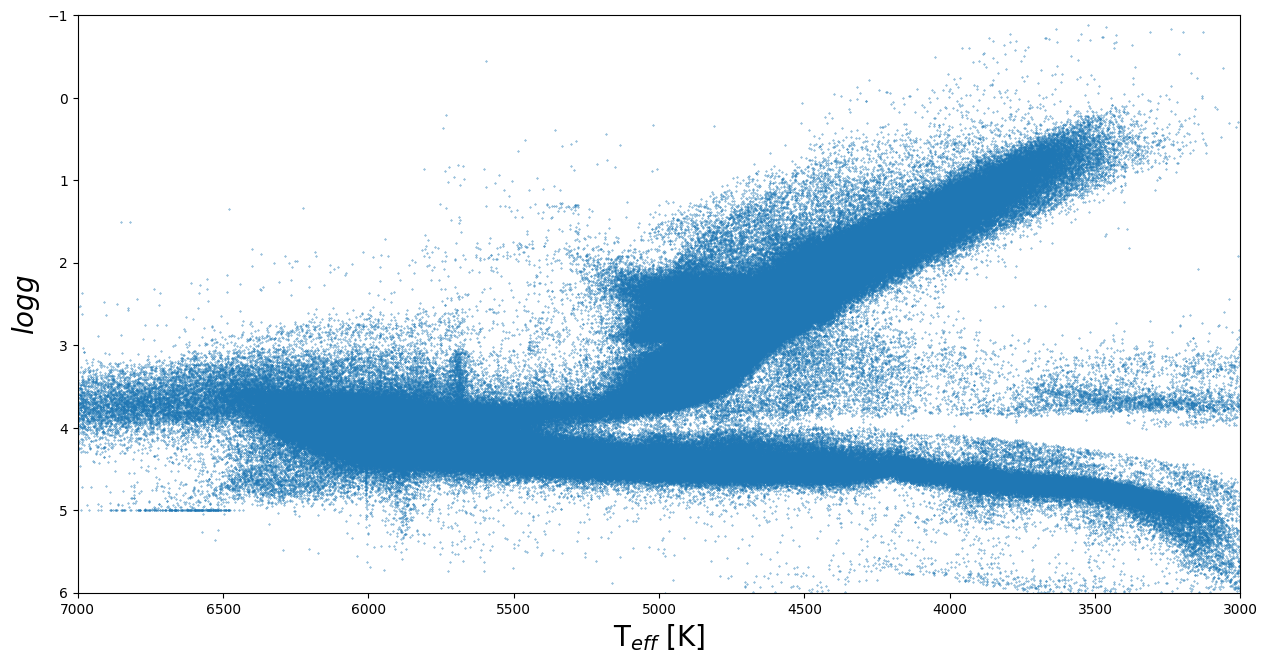

In [7]:
#Possible solution:

plt.figure(figsize=(15,7.5))
plt.scatter(data[mask_sp]['teff'],data[mask_sp]['logg'],s=0.1)
plt.xlabel('T$_{eff}$ [K]',fontsize=20)
plt.ylabel('$log g$',fontsize=20)
plt.xlim(7000,3000)
plt.ylim(6,-1)

<p>You should see a diagram with a few long thin blobs of points (a blob of points is technically called a locus of points). These blobs are stars at diffent stages in their evolution.</p>

<p>Let's consider giants and dwarfs. These are two different stages in a star's evolution. When a star is burning hydrogen it lies on the main sequence and is known as a dwarf star. Once it runs out of hydrogen fuel in its core it begins to evolve into a giant star. The star stays the same mass when it becomes a giant star, but it gets much bigger and cooler.</p>

<p>The acceleration due to gravity in a stars atmosphere depends on the star's mass $M$ and radius $R$:</p> 
$g=\frac{GM}{R^2}$

**Exercise:**
<ul>
    <li>How will a star getting larger as it evolves into a giant affect the acceleration due to gravity in its atmosphere</li>
    <li>How will this affect the $\log g$ value?</li>
    <li>Which blob (locus) of points do you think represents the giants on the plot you just made?</li>
</ul>

<p>Answers:</p>
<ul>
    <li>g will be less for a giant than a dwarf of the same size</li>
    <li>$\log g$ will also be less</li>
    <li>The blob going from (5500,3.8) to (3500,1) is the giants</li>
</ul>

<p>Now let's add another parameter to this plot, the metallicity ($[Fe/H]$). This is the log of the ratio of how many iron atoms a star contains compared to many hydrogen atoms. Stars have lots more hydrogen than iron so the scale for $[Fe/H]$ is generally defined so that the Sun would have $[Fe/H]$ of zero. This means that a star with $[Fe/H]=-1$ has one tenth of the metallicity of the Sun. Stars with low $[Fe/H]$ values are said to be metal-poor and those with higher values are said to be metal-rich.</p>

<p>Add the following parameters to your <code>plt.scatter</code> command <code>c=data[mask_sp]['fe_h'],vmin=-1.5,vmax=0.5</code> and add the following line to your plotting code <code>plt.colorbar(label='[Fe/H]')</code></p>

(6.0, -1.0)

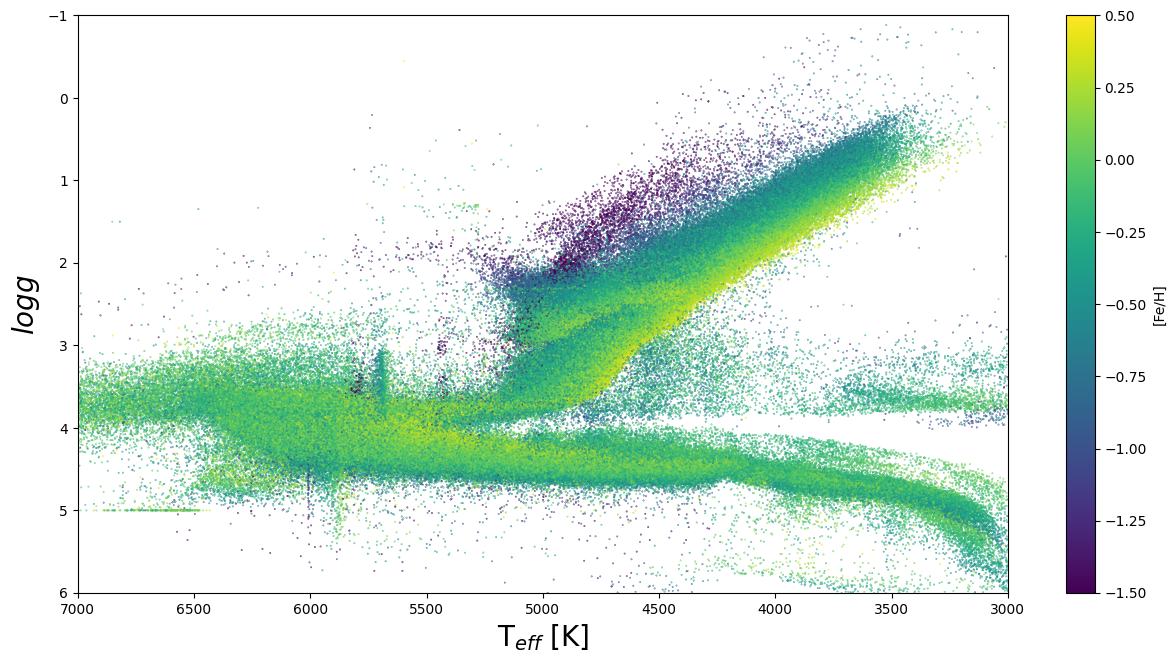

In [8]:
#enter your code here
#Possible solution:

plt.figure(figsize=(15,7.5))
plt.scatter(data[mask_sp]['teff'],data[mask_sp]['logg'], c=data[mask_sp]['fe_h'],s=0.1,vmin=-1.5,vmax=0.5)
plt.xlabel('T$_{eff}$ [K]',fontsize=20)
plt.ylabel('$log g$',fontsize=20)
plt.colorbar(label='[Fe/H]')
plt.xlim(7000,3000)
plt.ylim(6,-1)

<p>Have a look at the giant stars, do the metal poor giants have different effective temperatures and $\log g$ values from metal-rich ones?</p>

<p>Now let's use the combined SDSS and Gaia data to look at where stars lie in the galaxy. We'll start by creating a SkyCoord object.</p>

In [9]:
# use skycoord to input information
c = SkyCoord(ra=data['ra'][mask_sp]*u.deg, dec=data['dec'][mask_sp]*u.deg, 
             distance=(1/data['plx'][mask_sp])*u.kpc,
             pm_ra_cosdec=data['pmra'][mask_sp]*u.mas/u.yr, 
             pm_dec=data['pmde'][mask_sp]*u.mas/u.yr,
             radial_velocity=data['v_rad'][mask_sp]*u.km/u.s)

<p>This SkyCoord object includes the sky coordinates and distance for each star. These three bits of information allow us to describe the star's position in 3D space. Additionally we have some information about how each star is moving through space. One bit of information is the radial velocity of each star measured by SDSS using the doppler shift in a star's spectral lines. We also have Gaia's proper motions (a star's motion across the sky) for each star which gives us information about the velocities of each star in the plane of the sky. These three bits of information, which allow us to describe the star's motion in 3D space, are also included in the SkyCoord object.</p>

<p>So far we've only interacted with each star's position on the sky (its R.A. and Dec.). But since we also have the distance to each star from Gaia's trigonometric parallax we can also start to think in terms of a star's position in space. One coordinate system we can use is called galactocentric coordinates. This is a cartesian coordinate system where $x$, $y$ and $z$ are all zero at the center or the galaxy. The $x$-axis points from the Sun to the Galactic Centre, the $y$-axis points roughly in the direction of galactic rotation at the Sun's position and the $z$-axis is perpendicular to the Milky Way's disk. Both the $x$ and $y$ axes lie in the plane of the Milky Way's disk. In this system the Sun has a negative $x$ position.</p>

<img src="https://github.com/nialldeacon/SDSS_EPO/blob/main/images/galactocentric_cartesian.png?raw=true" style="height:200px" alt="A disk viewed almost edge-on with two axes in the plane of the disk and one axis normal to the disk. Arrows on the disk's edge point clockwise" />
<p>Image credit: Niall Deacon<br/>The galactocentric coordinate system with the Sun marked with a yellow symbol and the Galactic Center with a red symbol. The centre of the Galaxy's disk is the origin of the coordinate system. The arrows on the edge of the disk mark the direction of galactic rotation.</p>

<p>We can transform our SkyCoord object to the galactocentric coordinate system using the following code.</p>

In [10]:
# transform to galactocentric coordinate
galcen = c.transform_to(coord.Galactocentric(galcen_v_sun=[8, 254, 8] * u.km / u.s, galcen_distance=8.275 * u.kpc))


<p>We can then grab the positions and velocities from the SkyCoord object.</p>

In [11]:
x = galcen.x.value 
y = galcen.y.value
z = galcen.z.value


vx = galcen.v_x.value
vy = galcen.v_y.value
vz = galcen.v_z.value

<p>We can make one slight additional change to our coordinate system, going from a cartesian ($x$,$y$,$z$) system to a cylindrical system ($R$,$\phi$,$z$) where R is the distance from the Galactic Centre in the plane of the Galaxy and $\phi$ is the angle around the galactic disk in the direction of Galactic rotation. Here we define$\phi$ for the Sun to be at $\phi=180^{\circ}$ as the Sun has a negative $x$ position in the coordinate system we previosuly defined.</p>

<img src="https://github.com/nialldeacon/SDSS_EPO/blob/main/images/galactocentric_cylindrical.png?raw=true" style="height:200px" alt="A disk viewed almost edge-on with two axes in the plane of the disk and one axis normal to the disk. Arrows on the disk's edge point clockwise" />
<p>Image credit: Niall Deacon<br/>The galactocentric cylindrical coordinate system with the Sun marked with a yellow symbol and the Galactic Center with a red symbol. The centre of the Galaxy's disk is the origin of the coordinate system. The arrows on the edge of the disk mark the direction of galactic rotation.</p>

<p>We can transform our positions and velocities to the galactocentric cylindrical coordinate system using the following code (the $z$ coordinate stays the same).</p>

In [12]:
phi = np.arctan2(y, x)
R = np.sqrt(x**2+y**2)
vphi = vx*np.sin(phi)-vy*np.cos(phi)
vR = vx*np.cos(phi)+vy*np.sin(phi)

<p>Let's slice our data up by metallicity. We already made a selection for objects with good quality SDSS and Gaia data <code>mask_sp</code>, now we can use this mask to divide this selection of objects with good quality data a little further.</p>

<p>We can define a slice in our data for the lowest metallicity stars with the following code</p>

```python
    mask_feh1 = (data['fe_h'][mask_sp]<-1)
```

**Exercise:** split your sample up into four slices:
<ul>
    <li>$[Fe/H]$ < -1</li>
    <li>-1 < $[Fe/H]$ < -0.5</li>
    <li>-0.5 < $[Fe/H]$ < 0</li>
    <li>$[Fe/H]$ > 0</li>
</ul>

In [13]:
#Possible solution
mask_feh1 = (data['fe_h'][mask_sp]<-1)  
mask_feh2 = (data['fe_h'][mask_sp]<-0.5)& (data['fe_h'][mask_sp]>-1) 
mask_feh3 = (data['fe_h'][mask_sp]<0)& (data['fe_h'][mask_sp]>-0.5) 
mask_feh4 = (data['fe_h'][mask_sp]>0) 

<p>Now let's make some plots of the distribution of the stars in our different metallicity selections.</p>

**Exercise:** create histograms of the $z$ position coordinate for your four samples. Ensure that the range of $z$ values plotted is the same for all of the plots. You can add each histogram to the example code below.</p>

<Axes: >

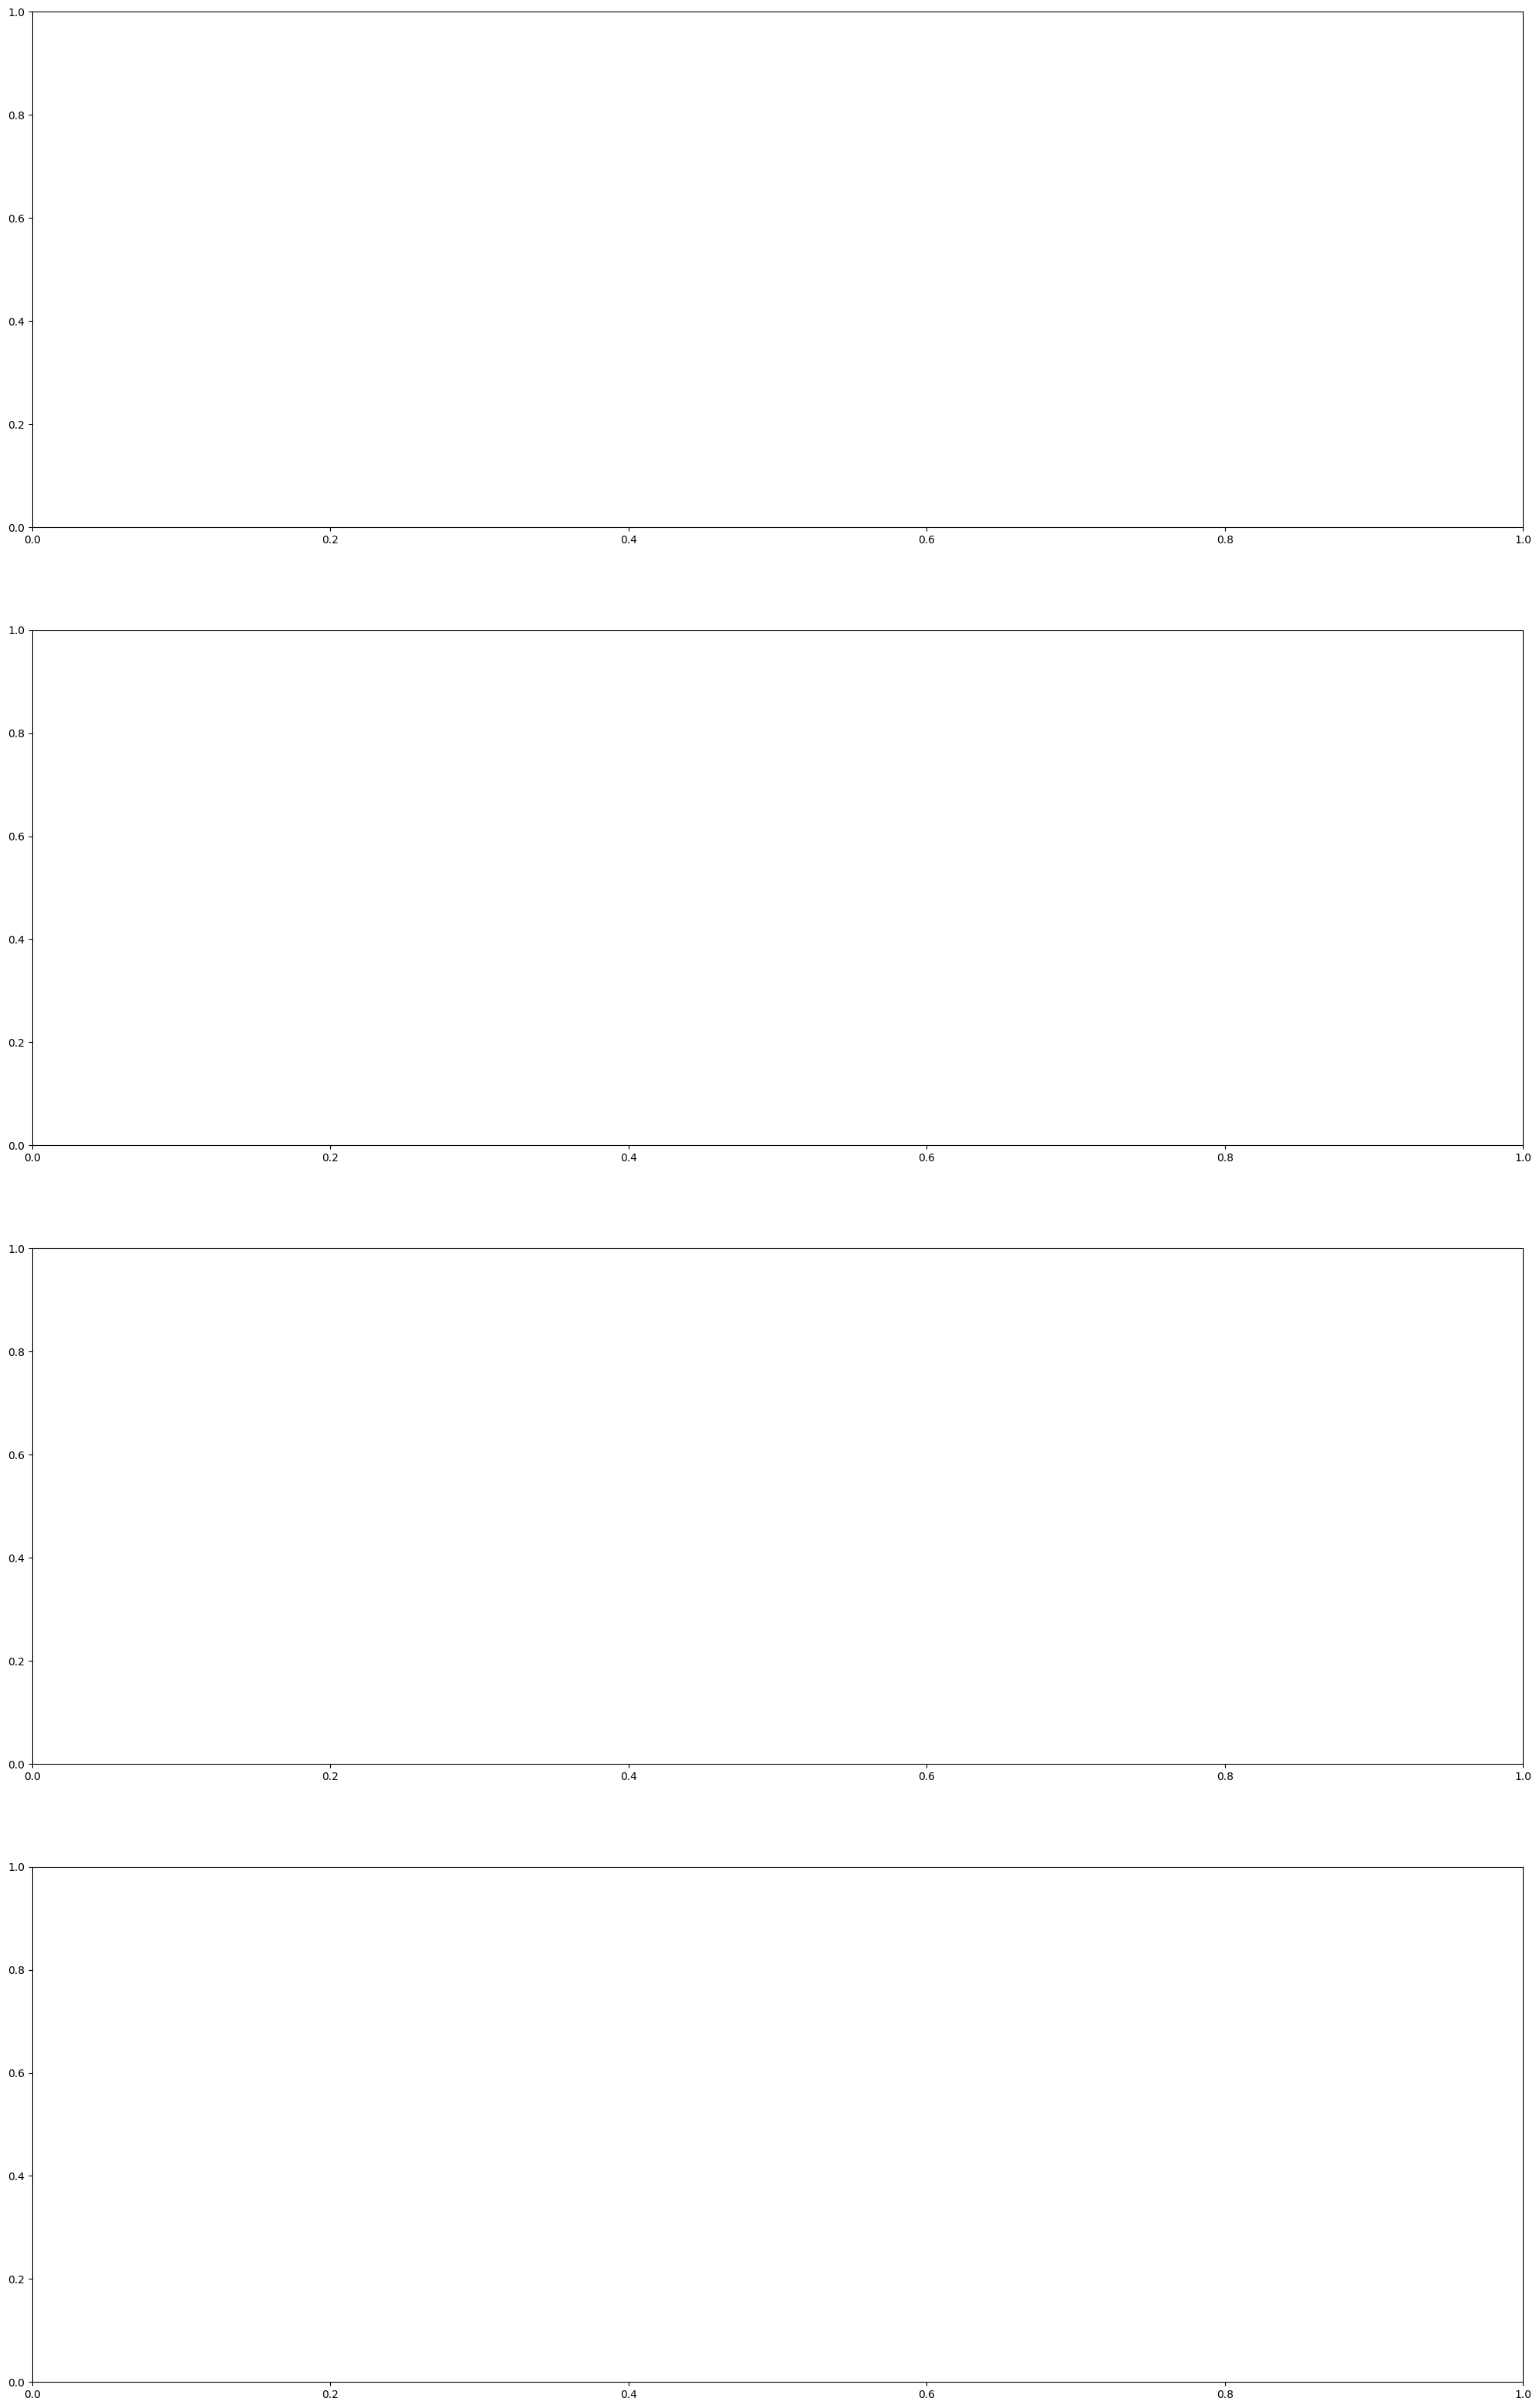

In [14]:
plt.figure(figsize=(25,40))
plt.subplot(4,1,1)
#plotting code here
plt.subplot(4,1,2)
#plotting code here
plt.subplot(4,1,3)
#plotting code here
plt.subplot(4,1,4)
#plotting code here

One Possible solution:

Text(0, 0.5, 'N')

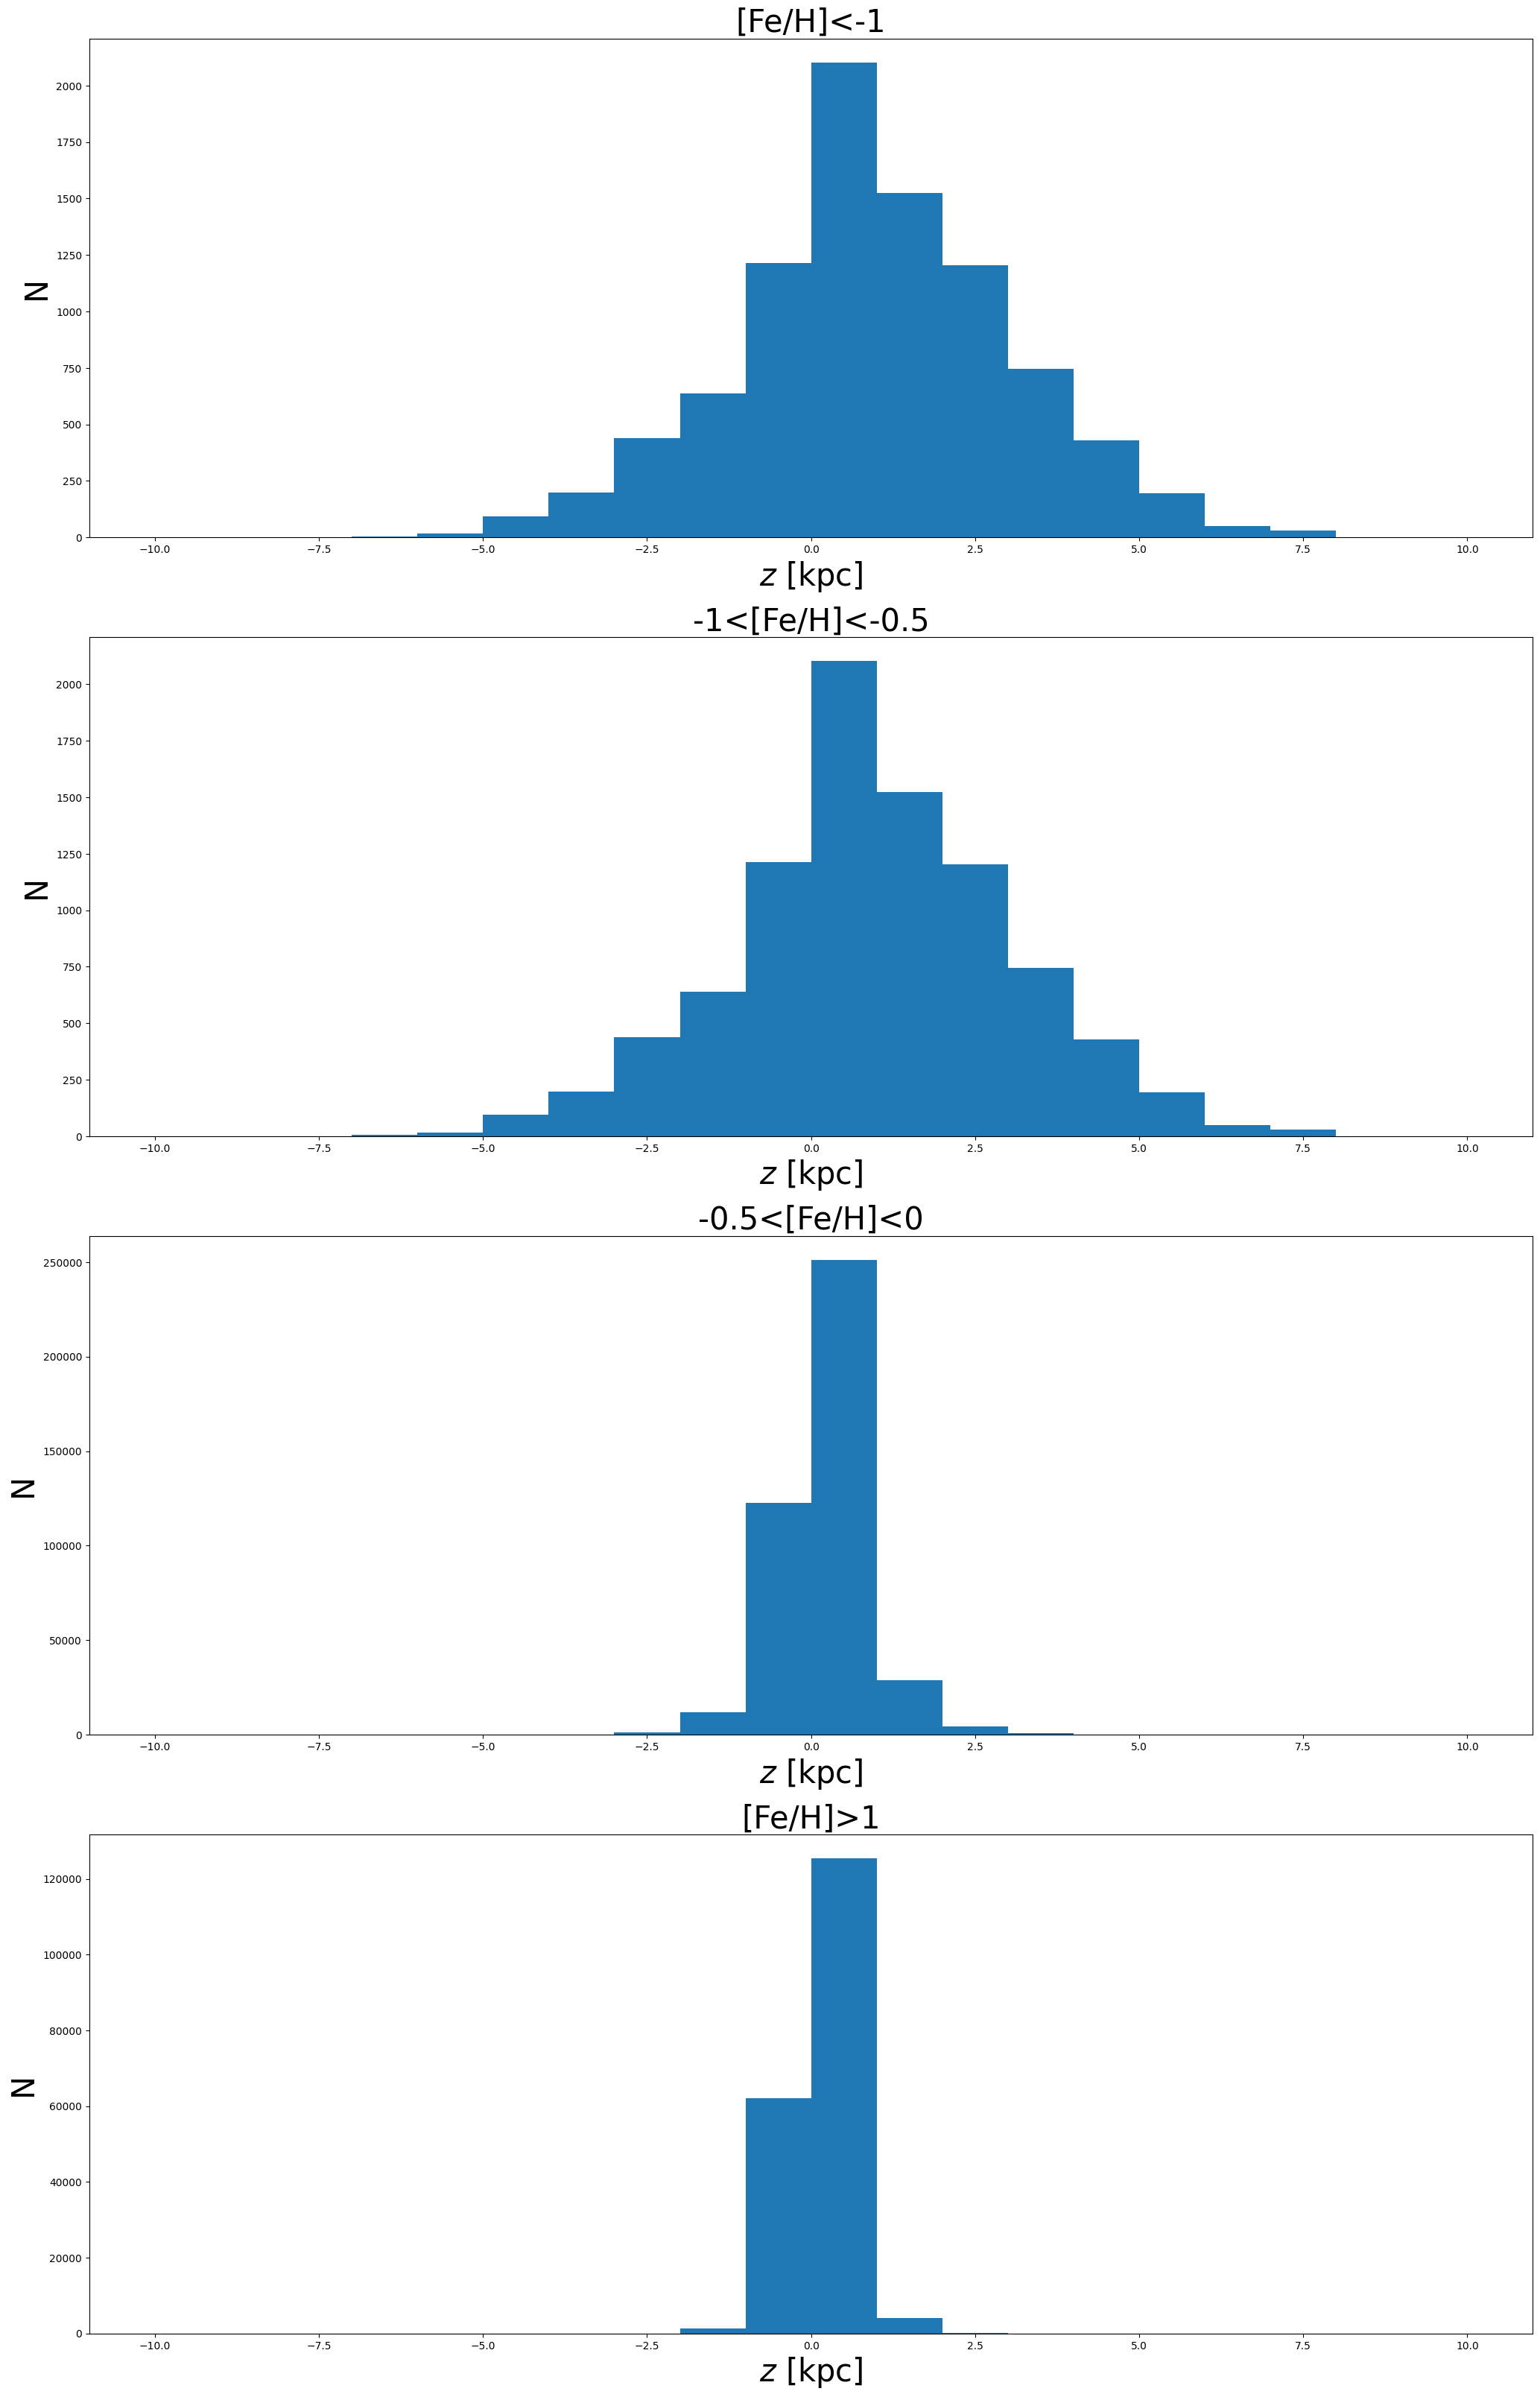

In [15]:
plt.figure(figsize=(25,40))
plt.subplot(4,1,1)
plt.title('[Fe/H]<-1',fontsize=30)
plt.hist(z[mask_feh1],bins=20,range=(-10,10))
plt.xlabel('$z$ [kpc]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,1,2)
plt.title('-1<[Fe/H]<-0.5',fontsize=30)
plt.hist(z[mask_feh1],bins=20,range=(-10,10))
plt.xlabel('$z$ [kpc]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,1,3)
plt.title('-0.5<[Fe/H]<0',fontsize=30)
plt.hist(z[mask_feh3],bins=20,range=(-10,10))
plt.xlabel('$z$ [kpc]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,1,4)
plt.title('[Fe/H]>1',fontsize=30)
plt.hist(z[mask_feh4],bins=20,range=(-10,10))
plt.xlabel('$z$ [kpc]',fontsize=30)
plt.ylabel('N',fontsize=30)

<p>Firstly it's important to note that the underlying dataset we are using is a bit biased. It is not a complete survey of all stars in the Galaxy and will likely have lots more stars closer to the Sun as these are easier to detect.</p>

**Exercise:** examine your plots. What happens to the distribution of stars in the $z$ direction? The $z$ coordinate measure the height above and below the plane of the disk of our Galaxy. What can you say about how spread out from the Galactic Disk the different metallicity samples are.

<p>Possible solution: The higher metallicity stars are more concentrated in the plane and tend to cluster more around the plane of the Galactic Disk.</p>

<p>Now let's look at how the stars in your different samples move in the galaxy.</p>

<p>Recall that we defined the positions and motions of each star in terms of three coordinates $R$, $\phi$ and $z$.</p>
<img src="https://github.com/nialldeacon/SDSS_EPO/blob/main/images/galactocentric_cylindrical.png?raw=true" style="height:200px" alt="A disk viewed almost edge-on with two axes in the plane of the disk and one axis normal to the disk. Arrows on the disk's edge point clockwise" />

**Exercise:** Think about a star orbiting the centre of the Galaxy with an orbital velocity of 200km/s in a circular orbit exactly in the plane of the Galaxy ($z=0$). What, roughly do you think velocities would be in the $R$, $\phi$ and $z$ directions ($V_R$, $V_{\phi}$ and $V_z$)?

<p>Answer: $V_R$ and $V_z$ would be roughly zero and $V_{\phi}$ would be roughly 200km/s</p>

**Exercise:** Now let's think about a star in an elliptical orbit in the disk. How would the values of $V_R$, $V_{\phi}$ and $V_z$ look for this?

<p>Answer: $V_R$ would be non-zero. The value of $V_R$ and $V_{\phi}$ would change throughout the orbit but I don't think the student needs to know that to understand the point.</p>

<p>Now let's think about a star in a circular orbit which is tilted with respect to the disk so that it spends half its orbit above the disk and half below. How would the values of $V_R$, $V_{\phi}$ and $V_z$ look for this?</p>

<p>Answer: $V_z$ would be non-zero. There would also be some change to $V_R$ as $R$ is only the distance from the Galactic Centre in the plane of the Galaxy but the student doesn't need to answer that to understand the point.</p>

<p>Let's see how the orbits of the stars in your different samples compare to the circular orbit in the disk you just considered.</p>

**Exercise:** for each of your four samples, make three histograms, one each for $V_R$, $V_{\phi}$ and $V_z$.<br/>
Hint: You might want to set out your plots in an array with four rows and three columns with the three plots for each metallicity samples all on the same row.<br/>
Further hint: set the ranges for the histograms to be between -400 and 400

Text(0, 0.5, 'N')

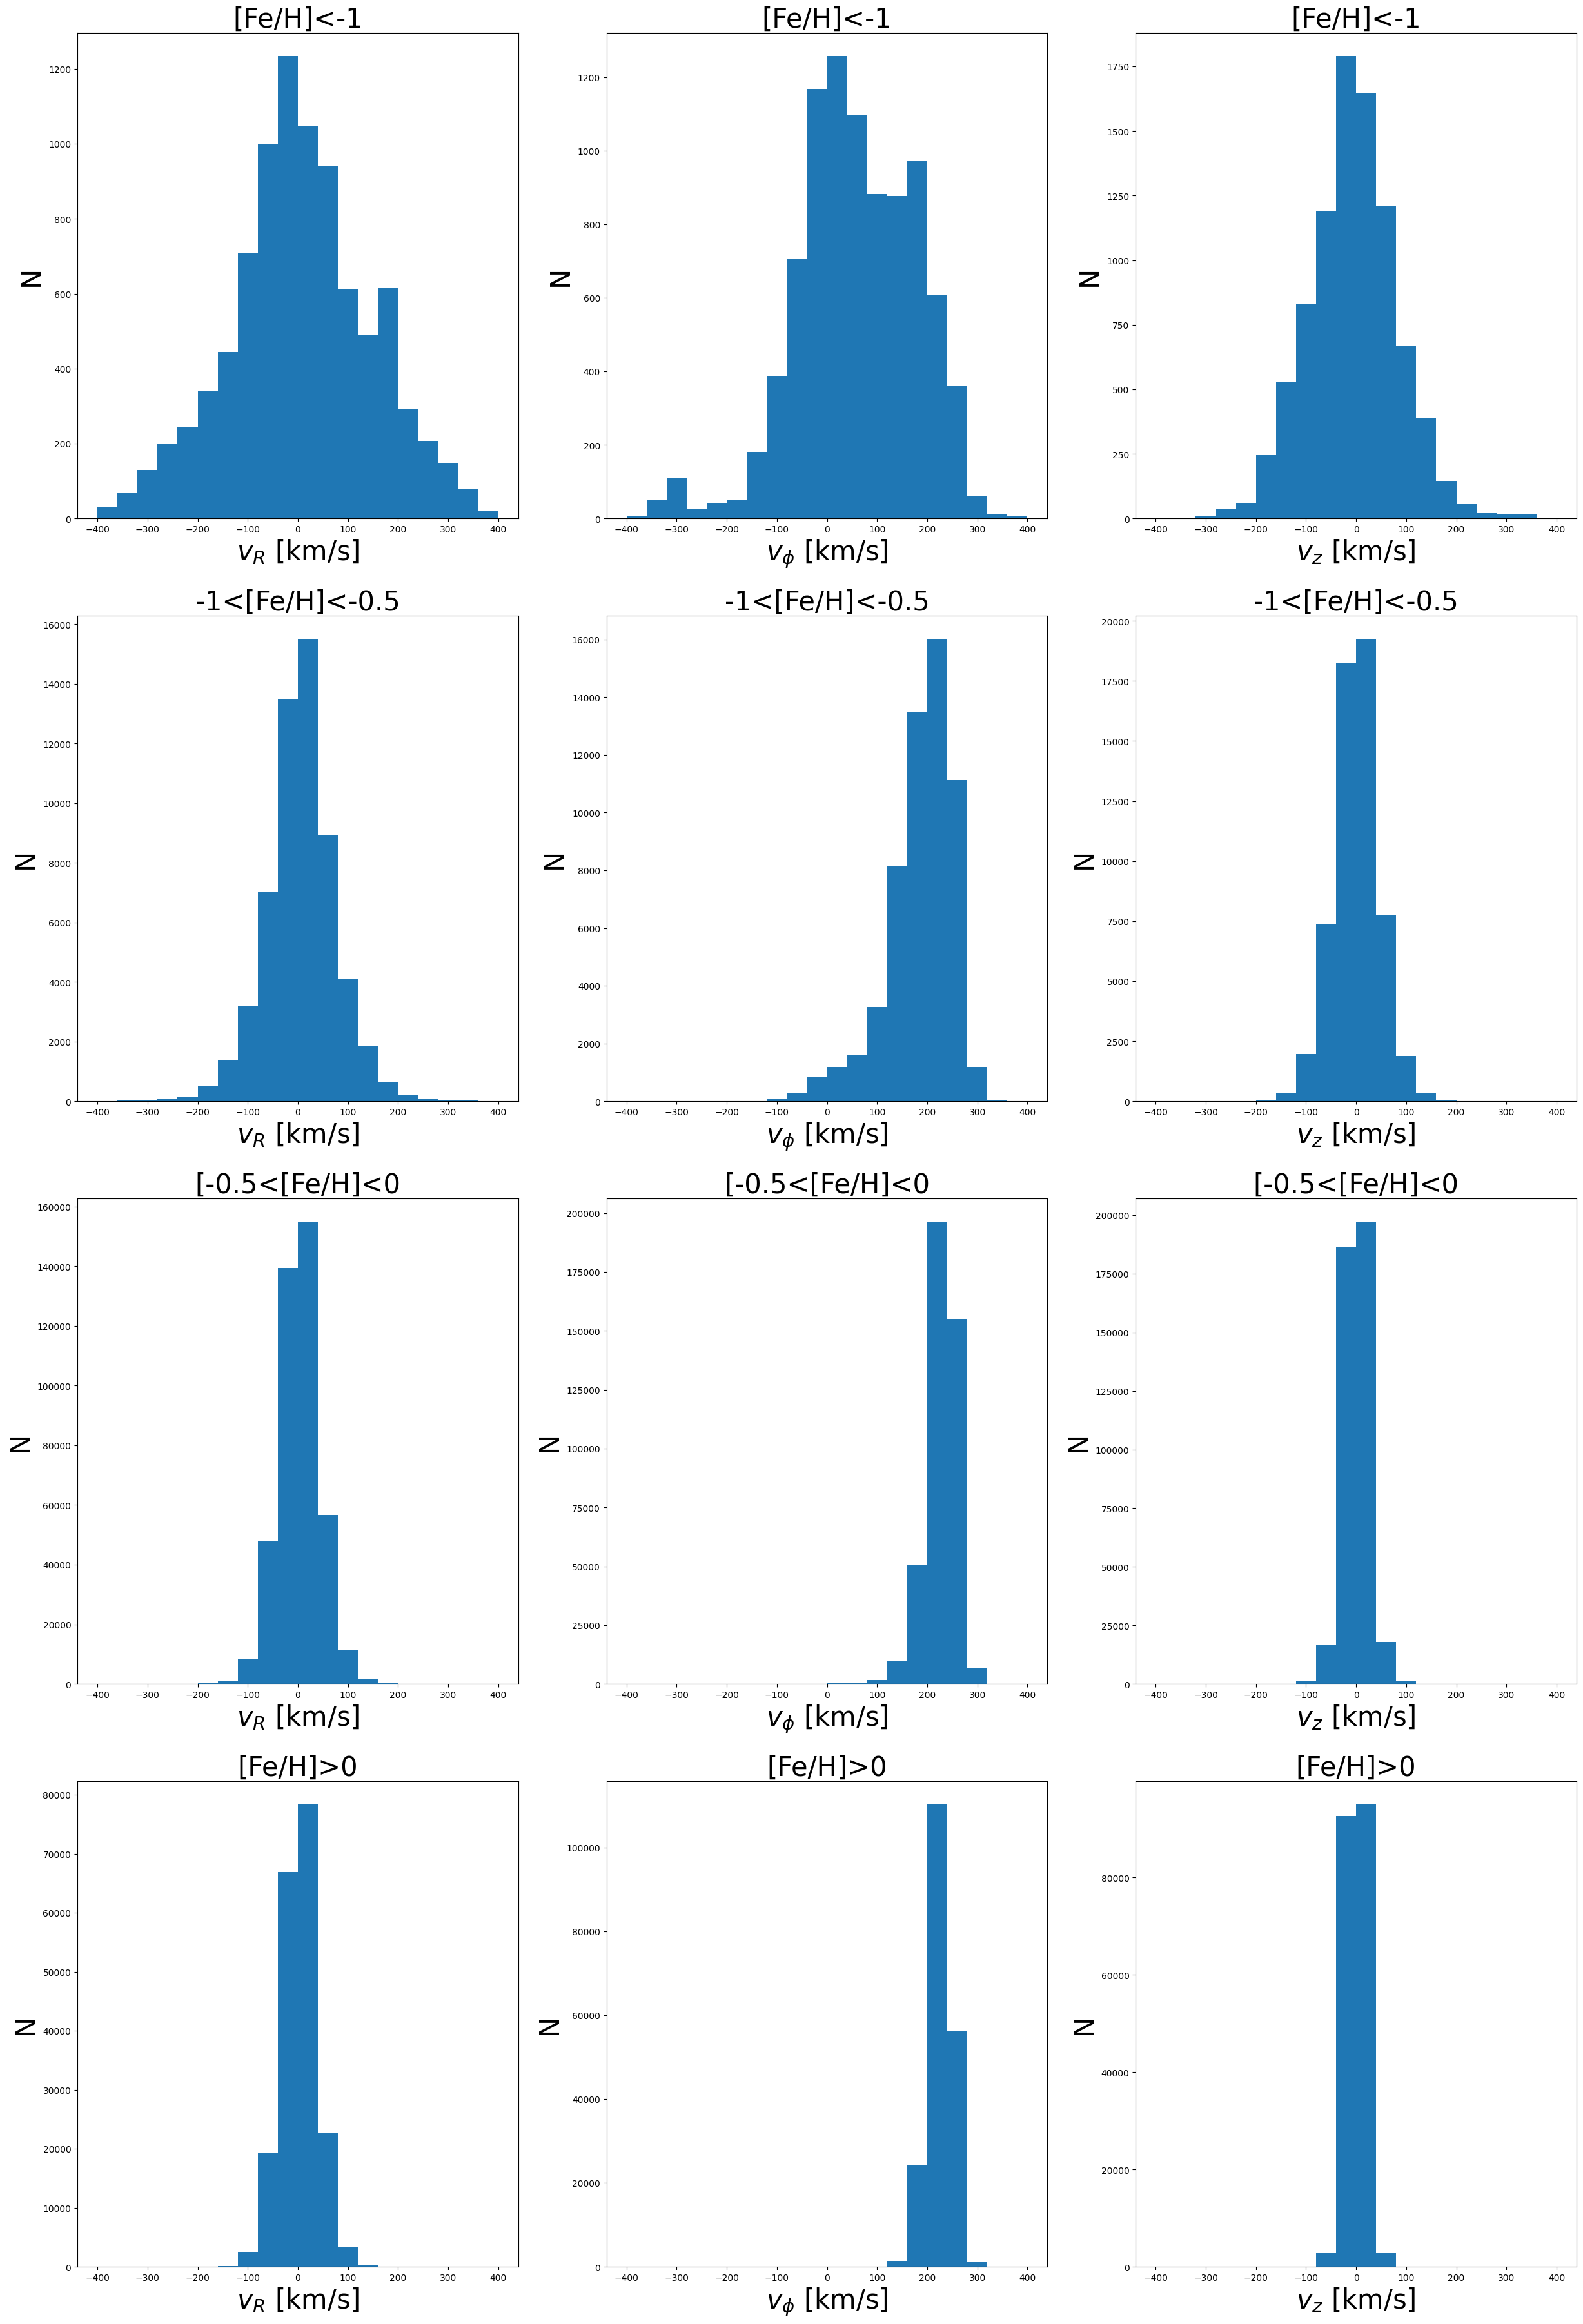

In [16]:
#possible solution

plt.figure(figsize=(30,45))
plt.subplot(4,3,1)
plt.title('[Fe/H]<-1',fontsize=30)
plt.hist(vR[mask_feh1],bins=20,range=(-400,400))
plt.xlabel('$v_R$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,3,2)
plt.title('[Fe/H]<-1',fontsize=30)
plt.hist(vphi[mask_feh1],bins=20,range=(-400,400))
plt.xlabel('$v_{\phi}$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,3,3)
plt.title('[Fe/H]<-1',fontsize=30)
plt.hist(vz[mask_feh1],bins=20,range=(-400,400))
plt.xlabel('$v_z$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)

plt.subplot(4,3,4)
plt.title('-1<[Fe/H]<-0.5',fontsize=30)
plt.hist(vR[mask_feh2],bins=20,range=(-400,400))
plt.xlabel('$v_R$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,3,5)
plt.title('-1<[Fe/H]<-0.5',fontsize=30)
plt.hist(vphi[mask_feh2],bins=20,range=(-400,400))
plt.xlabel('$v_{\phi}$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,3,6)
plt.title('-1<[Fe/H]<-0.5',fontsize=30)
plt.hist(vz[mask_feh2],bins=20,range=(-400,400))
plt.xlabel('$v_z$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)

plt.subplot(4,3,7)
plt.title('[-0.5<[Fe/H]<0',fontsize=30)
plt.hist(vR[mask_feh3],bins=20,range=(-400,400))
plt.xlabel('$v_R$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,3,8)
plt.title('[-0.5<[Fe/H]<0',fontsize=30)
plt.hist(vphi[mask_feh3],bins=20,range=(-400,400))
plt.xlabel('$v_{\phi}$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,3,9)
plt.title('[-0.5<[Fe/H]<0',fontsize=30)
plt.hist(vz[mask_feh3],bins=20,range=(-400,400))
plt.xlabel('$v_z$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)

plt.subplot(4,3,10)
plt.title('[Fe/H]>0',fontsize=30)
plt.hist(vR[mask_feh4],bins=20,range=(-400,400))
plt.xlabel('$v_R$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,3,11)
plt.title('[Fe/H]>0',fontsize=30)
plt.hist(vphi[mask_feh4],bins=20,range=(-400,400))
plt.xlabel('$v_{\phi}$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.subplot(4,3,12)
plt.title('[Fe/H]>0',fontsize=30)
plt.hist(vz[mask_feh4],bins=20,range=(-400,400))
plt.xlabel('$v_z$ [km/s]',fontsize=30)
plt.ylabel('N',fontsize=30)

**Exercise:** Examine your plots and answer the following questions
<ul>
    <li>Which of your subsamples have the orbits that are most like the circular orbit in the plane of the Galaxy that we previously talked about?</li>
    <li>What, roughly is the orbital velocity for these stars?</li>
    <li>Which of the subsamples have orbits that are least like this?</li>
    <li>Can you see a trend between metallicity and the orbits of stars in the Galaxy?</li>
    <li>Can you see a trend between metallicity and the dispersion (width of the distribution) of each of the velocity components</li>
</ul>    
     The first generations of stars formed after the Big Bang had almost no metals in them and were therefore very metal-poor. Thoses burned hydrogen into heavier elements they enriched the gas in the Galaxy with metals. The stars that formed from this gas thus became more metal rich. As time went on, this constant enrichment process led to each successive generation of stars becoming more metal rich.</p>
<ul>
    <li>What can you say about the ages of stars that follow relatively circular orbits in the plane of the Milky Way compared to stars with other orbits?</li>
</ul>
    

<p>Answers:
<ul>
    <li>The more metal-rich stars have relatively circular, disk-like orbits</li>
    <li>Something between 200 and 250 km/s would be a reasonable answer</li>
    <li>The more metal-poor stars have orbits that deviate much more from the disk, having more tilted orientations w.r.t. the disk</li>
    <li>There is a trend with orbits looking more disk-like with increasing metallicity</li>
    <li>More metal-poor stars have a wider dispersion in orbital velocity components</li>
    <br/>
    <li>Younger, more metal-rich stars tend to have disk-like orbits</li>
</ul>

### About this notebook

This notebook was created to demonstrate basic usage of the astarAllStarASPCAP file, and how to create some well known figures using that file.

**Authors**: Niall Deacon, with thanks to Danny Horta and Lucy Liu

**Last Update**: 2025 Jun 24

If you use `astropy`  for published research, please cite the
authors. Follow this link for more information about citing `astropy`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)

And of course please [cite](https://sdss.org/collaboration/citing-sdss/) SDSS when you use our data.